In [1]:
#####################################################################################################################
#Developed by Jonathan Ojeda 8/1/2021 QAAFI UQ
# Code functionalities:
# In order to study the interactions between G and M under different climate conditions, climate zones
# can be created by kmeans clustering (Arthur and Vassilvitskii, 2007). The clustering is applied separately 
# to average mean daily temperature, sum solar radiation and rainfall during the crop growing season.

#Arthur, D., Vassilvitskii, S., 2007. k-means + +: the advantages of careful seeding.
#In: Proceedings of the Eighteenth Annual ACM-SIAM Symposium on Discrete
#Algorithms Society for Industrial and Applied Mathematics, New Orleans,
#Louisiana, pp. 1027–1035.
#####################################################################################################################

In [132]:
#import libraries
import random as rd
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
import cartopy.io.shapereader as shpreader
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

from sklearn.cluster import KMeans

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [162]:
#Read mean created using nco from Linux
#data0 = xr.open_dataset(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\new\mean.nc', decode_times=False)

#Read output from psims
data00 = xr.open_dataset(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/outputs/new/run009/output.nc4', decode_times=False) 

# replace all values equal to -99 with np.nan
#data_mean = data0.where(data0['biomass'] != -99.)
dataPre4 = data00.where(data00['biomass'] != -99.)
dataPre3 = dataPre4.where(dataPre4['FloweringDAS'] != -99.)
dataPre2 = dataPre3.where(dataPre3['MaxLAI'] != -99.)

# Extract single lat/long combination for a particular variable
#data2 = dataPre2.where(dataPre2.biomass != dataPre2.biomass[8,0:,0:,73,0:], drop=True)

#Conver multidimendional frame to 2D frame
data2pd = dataPre2.to_dataframe()
dfc = data2pd[data2pd.biomass != 0]
dfc.reset_index(level=[0,1,2,3,4], inplace=True)

#Change name of column
dfc.rename(columns={'scen_new':'cultivar'}, inplace=True)
df = dfc.dropna()
df0 = df.where(df['biomass'] != 0)
X=df0.groupby(['lat','lon'])[['RadiationIn','TempIn','RainIn','biomass']].mean()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [163]:
X

RadiationIn     TempIn      RainIn       biomass
lat   lon                                                     
25.25 -81.25  2627.772461  28.674433  692.770203  19052.826172
      -80.75  2420.464111  28.193768  778.599060  17342.443359
      -80.25  2424.868652  28.495199    0.000000  17770.906250
25.75 -81.75  2657.744629  28.575100  759.217651  19231.335938
      -81.25  2562.654785  28.167534  859.205811  18387.492188
...                   ...        ...         ...           ...
49.75 -94.25  2186.498291  17.480425  350.907501   8700.721680
      -93.75  2161.844238  17.096392  361.716339   7856.242676
      -93.25  2154.164551  16.918558  375.615326   7460.859375
      -92.75  2155.366943  16.987267  384.404541   7664.949707
      -92.25  2146.610840  16.906925  375.127655   7509.831543

[2026 rows x 4 columns]

In [164]:
#Calculate clusters using k-means

kmeans = KMeans(n_clusters=4, n_init=200) #algorithm='elkan'

y = kmeans.fit_predict(X[['TempIn','RainIn','RadiationIn']])

X['env'] = y
#print(X)

In [165]:
#Calculate means and SD for Rad, Rain and Temp in each environment
mean_env = X.groupby(['env'])[['RadiationIn','TempIn','RainIn']].mean().round(decimals=2)
mean_env.rename(columns={'RadiationIn':'RadiationIn_m','TempIn':'TempIn_m','RainIn':'RainIn_m'}, inplace=True)

sd_env = X.groupby(['env'])[['RadiationIn','TempIn','RainIn']].std().round(decimals=2)
sd_env.rename(columns={'RadiationIn':'RadiationIn_sd','TempIn':'TempIn_sd','RainIn':'RainIn_sd'}, inplace=True)
sd_env

envs = pd.concat([mean_env, sd_env], axis=1)
#envs.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\envs2.csv')

In [166]:
envs

,RadiationIn_m,TempIn_m,RainIn_m,RadiationIn_sd,TempIn_sd,RainIn_sd
env,,,,,,
0,2738.760010,25.629999,233.589996,109.67,2.43,55.67
1,2263.510010,21.090000,386.529999,75.57,2.94,48.52
2,2466.209961,23.530001,367.839996,63.67,2.71,65.11
3,2391.260010,27.070000,634.950012,108.43,0.75,85.49


In [167]:
#Convert dataframe to xarray to plot
df_env = X.to_xarray()
df_env

<xarray.Dataset>
Dimensions:      (lat: 50, lon: 68)
Coordinates:
  * lat          (lat) float64 25.25 25.75 26.25 26.75 ... 48.75 49.25 49.75
  * lon          (lon) float64 -105.8 -105.2 -104.8 ... -73.25 -72.75 -72.25
Data variables:
    RadiationIn  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    TempIn       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    RainIn       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    biomass      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    env          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

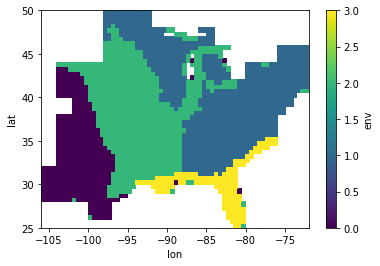

In [168]:
df_env.env[0:,0:].plot(yincrease=True, x='lon', y='lat')

In [171]:
#Create name for environments
X.loc[X.env == 1, 'env_name'] = "East"
X.loc[X.env == 3, 'env_name'] = "Mid"
X.loc[X.env == 0, 'env_name'] = "West"
X.loc[X.env == 2, 'env_name'] = "South"

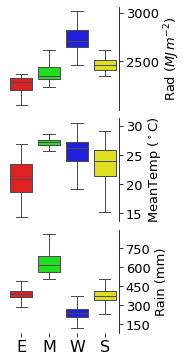

In [172]:
color_dict = dict({'East':'#ff0101','Mid':'#00ff01','West': '#0000fe','South': 'yellow'})

fig= plt.figure(figsize=(2,6))

plt.subplot(3, 1, 1)
ax=sns.boxplot(x="env_name", order=['East','Mid','West','South'], y="RadiationIn", data=X, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rad ($MJ\,m^{-2}$)', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=13)
ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])

plt.subplot(3, 1, 2)
ax=sns.boxplot(x="env_name", order=['East','Mid','West','South'], y="TempIn", data=X, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('MeanTemp ($^\circ$C)', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=13)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])

plt.subplot(3, 1, 3)
ax=sns.boxplot(x="env_name", order=['East','Mid','West','South'], y="RainIn", data=X, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rain (mm)', fontsize =13)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

pos   = [0,1,2,3]
label = ['E','M','W','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplots_adjust(wspace=0, hspace=0.08)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs_clim.png', dpi=600,bbox_inches='tight')

hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-159-ff5276856a63>:60: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


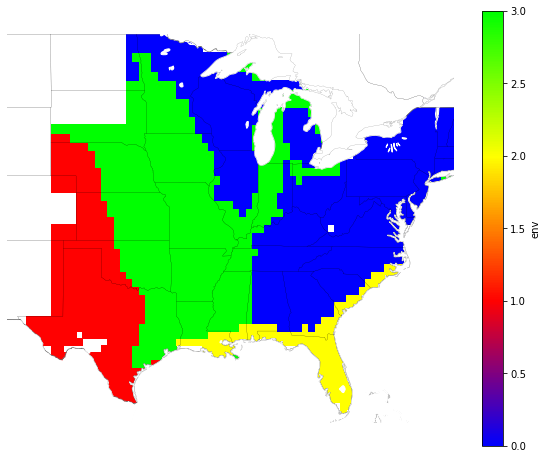

In [159]:
#Plotting map with environmental zones
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

colors = ['#0000fe','#ff0101','yellow','#00ff01']
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

p=df_env.env.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=cm, add_colorbar=True, zorder=1, vmin=0, vmax=3)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='white',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, color='k')
ax.add_feature(cfeature.STATES, linewidth=0.1, zorder=3)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, color='grey')
ax.add_feature(cfeature.LAND, color='white',zorder=0.5)
ax.set_extent([-107.5, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
# cb = plt.colorbar(p, orientation="horizontal", pad=0.05, shrink=0.55, ticks=[0,1,2,3])
# cb.set_label(label='', size='xx-large', weight='bold', labelpad=50)
# cb.ax.tick_params(labelsize='x-large')
# cb.set_ticks([])

#fig.text(0.36, 0.19, 'HLL', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.49, 0.19, 'LHH', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.63, 0.19, 'MLM', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.63, 0.19, 'MLM', va='center', rotation='horizontal', fontsize =17)

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\MAP.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [160]:
X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv.csv')

In [154]:
#Merge dataframes to integrate the environment column with other variables
new = pd.merge(X, df0, how ='inner', on =['lat','lon']) 
new2=new.drop(['RadiationIn_y','TempIn_y','RainIn_y','biomass_x'], axis=1)
new2.rename(columns={'RadiationIn_x':'RadiationIn','TempIn_x':'TempIn','RainIn_x':'RainIn','biomass_y':'biomass'}, inplace=True)

#Change name of environments accordingly with levels of rad, rain and temp

new2.loc[new2.irr == 1, 'irr_name'] = "rainfed"
new2.loc[new2.irr == 2, 'irr_name'] = "irrigated"

new2.loc[new2.cultivar == 0, 'cv'] = "GS"
new2.loc[new2.cultivar == 1, 'cv'] = "SS"
new2.loc[new2.cultivar == 2, 'cv'] = "FSPS"
new2.loc[new2.cultivar == 3, 'cv'] = "FS"

<AxesSubplot:ylabel='Frequency'>

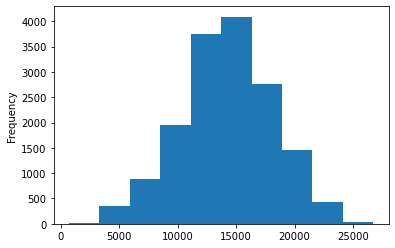

In [145]:
#Calculate means before the plot
mean=new2.groupby(['env_name','irr_name'])[['biomass']].mean().round(decimals=0)

a=new2.groupby(['env_name','irr_name','cultivar','lat','lon'])[['biomass']].mean().round(decimals=0)
a.biomass.plot.hist()

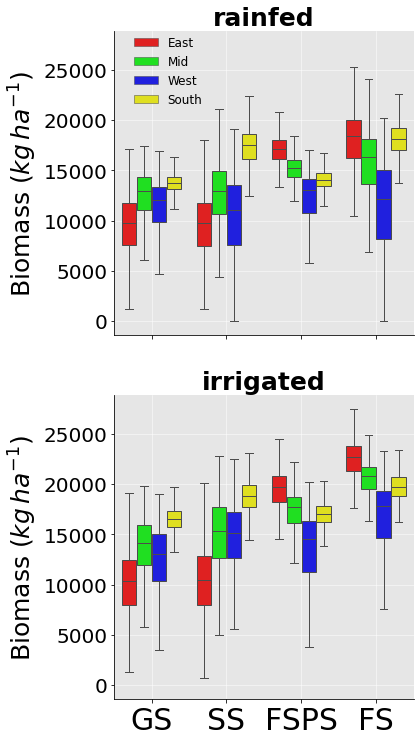

In [152]:
#Plot biomass by environment, cultivar and irrigation management
color_dict = dict({'East':'#ff0101','Mid':'#00ff01','West': '#0000fe','South': 'yellow'})

tkt_plot_detailed =sns.catplot(x="cv", order=['GS','SS','FSPS','FS'], y="biomass", data=new2, hue='env_name', 
                               hue_order=['East','Mid','West','South'], linewidth=1, kind='box', col='irr_name', 
                               col_wrap=1, legend=False, showfliers = False, palette=color_dict)

tkt_plot_detailed.set_axis_labels("", "Biomass ($kg\,ha^{-1}$)",fontsize= 25)
tkt_plot_detailed.set_titles(col_template="{col_name}", fontweight='bold', size=25)

for ax in tkt_plot_detailed.axes.flatten():

    ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
    ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
    ax.patch.set_facecolor('0.90')
    ax.set_axisbelow(True)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    pos   = [0, 1, 2, 3]
    label = ['GS','SS','FSPS','FS']
    ax.set_xticks(pos)
    ax.set_xticklabels(label)

plt.legend(prop=dict(size=12),bbox_to_anchor=(0.05, 2.2), loc=2, borderaxespad=0., frameon=False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs.png', dpi=300,bbox_inches='tight')
hide_toggle()

In [157]:
new2.biomass2.describe()

count    471240.000000
mean         14.259617
std           4.388433
min           0.016000
25%          11.533500
50%          14.492200
75%          17.306400
max          28.842400
Name: biomass2, dtype: float64

(0.0, 29.0)

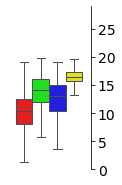

In [158]:
#Create subset of dataframes to create singular plots for biomass
new2['biomass2']=new2['biomass']/1000

rainfed = new2.where(new2['irr_name'] == 'rainfed')
irrigated = new2.where(new2['irr_name'] == 'irrigated')

GSd = rainfed.where(rainfed['cv'] == 'GS')
SSd = rainfed.where(rainfed['cv'] == 'SS')
FSPSd = rainfed.where(rainfed['cv'] == 'FSPS')
FSd = rainfed.where(rainfed['cv'] == 'FS')

GSi = irrigated.where(irrigated['cv'] == 'GS')
SSi = irrigated.where(irrigated['cv'] == 'SS')
FSPSi = irrigated.where(irrigated['cv'] == 'FSPS')
FSi = irrigated.where(irrigated['cv'] == 'FS')

#Plot biomass by environment, cultivar and irrigation management

fig = plt.figure(figsize=(1.5,3))
color_dict = dict({'East':'#ff0101','Mid':'#00ff01','West': '#0000fe','South': 'yellow'})
ax=sns.boxplot(x="cv", y="biomass2", data=GSi, hue='env_name', hue_order=['East','Mid','West','South'], linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =13)
plt.xlabel('', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_ylim([0,29])

#fig.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\env1.png', dpi=300,bbox_inches='tight',transparent=True)

In [17]:
#Saving xarray as nc file
#df_env.to_netcdf(r"C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\env.nc")